# [Damped Oscillator - CDE](https://github.com/Ziaeemehr/vbi_paper/blob/main/docs/examples/damp_oscillator_cde.ipynb)

- Inference without torch dependency:
    - DMN
    - MAF

<a href="https://colab.research.google.com/github/Ziaeemehr/vbi_paper/blob/main/docs/examples/damp_oscillator_cde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# # Install VBI package in Google Colab (lightweight, CPU-only version)
# print("Setting up VBI for Google Colab...")

# # Skip C++ compilation for faster installation in Colab
# %env SKIP_CPP=1

# # Install the package
# !pip install vbi

# print("VBI package installed successfully! Ready to proceed.")

In [1]:
import pickle
import corner
import numpy as np
from vbi import BoxUniform
import autograd.numpy as anp
import matplotlib.pyplot as plt
from multiprocessing import Pool
from vbi.cde import MDNEstimator, MAFEstimator
from sklearn.preprocessing import StandardScaler
from vbi.models.numba.damp_oscillator import DO
from vbi.utils import posterior_shrinkage_numpy, posterior_zscore_numpy
# switch to C++ implementation
# from vbi.models.cpp.damp_oscillator import DO

In [2]:
from vbi import report_cfg
from vbi import extract_features
from vbi import get_features_by_domain, get_features_by_given_names

In [3]:
seed = 2
np.random.seed(seed)

In [4]:
parameters = {
    "a": 0.1,
    "b": 0.05,
    "dt": 0.01,
    "t_start": 0,
    "method": "rk4",
    "t_end": 100.0,
    "t_cut": 20,
    "output": "output",
    "initial_state": [0.5, 1.0],
}

In [5]:
ode = DO(parameters)
print(ode())

Damped Oscillator Model (Numba)
-------------------------------
a = 0.1
b = 0.05
dt = 0.01
t_start = 0.0
t_end = 100.0
t_cut = 20.0
method = rk4
output = output
initial_state = [0.5 1. ]


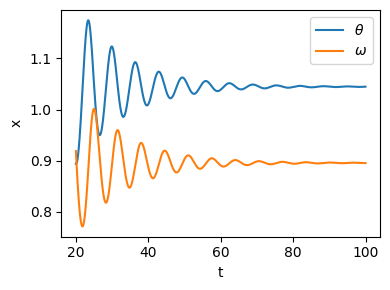

In [6]:
sol = ode.run()
t = sol["t"]
x = sol["x"]
plt.figure(figsize=(4, 3))
plt.plot(t, x[:, 0], label="$\\theta$")
plt.plot(t, x[:, 1], label="$\omega$")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.tight_layout()

In [7]:
cfg = get_features_by_domain(domain="statistical")
cfg = get_features_by_given_names(cfg, names=["calc_std", "calc_mean"])
report_cfg(cfg)

Selected features:
------------------
■ Domain: statistical
 ▢ Function:  calc_std
   ▫ description:  Computes the standard deviation of the signal.
   ▫ function   :  vbi.feature_extraction.features.calc_std
   ▫ parameters :  {'indices': None, 'verbose': False}
   ▫ tag        :  all
   ▫ use        :  yes
 ▢ Function:  calc_mean
   ▫ description:  Computes the mean of the signal.
   ▫ function   :  vbi.feature_extraction.features.calc_mean
   ▫ parameters :  {'indices': None, 'verbose': False}
   ▫ tag        :  all
   ▫ use        :  yes


In [8]:
def wrapper(par, control, cfg, verbose=False):
    ode = DO(par)
    sol = ode.run(control)

    # extract features
    fs = 1.0 / par["dt"] * 1000  # [Hz]
    stat_vec = extract_features(
        ts=[sol["x"].T], cfg=cfg, fs=fs, n_workers=1, verbose=verbose
    ).values
    return stat_vec[0]

In [9]:
def batch_run(par, control_list, cfg, n_workers=1):
    stat_vec = []
    with Pool(processes=n_workers) as pool:
        stat_vec = pool.starmap(
            wrapper, [(par, control, cfg) for control in control_list]
        )
    return stat_vec

In [10]:
control = {"a": 0.11, "b": 0.06}
x_ = wrapper(parameters, control, cfg)
print(x_)

[0.02651486 0.02314122 1.0525634  0.88261193]


In [11]:
num_sim = 2000
num_workers = 10
a_min, a_max = 0.0, 1.0
b_min, b_max = 0.0, 1.0
prior_min = [a_min, b_min]
prior_max = [a_max, b_max]
prior = BoxUniform(low=prior_min, high=prior_max, seed=seed)


In [12]:
theta = prior.sample(num_sim)
control_list = [{"a": theta[i, 0], "b": theta[i, 1]} for i in range(num_sim)]

In [13]:
stat_vec = batch_run(parameters, control_list, cfg, n_workers=4)

In [14]:
scaler = StandardScaler()
stat_vec = scaler.fit_transform(np.array(stat_vec))

In [15]:
# stat_vec = np.array(stat_vec)
theta.shape, stat_vec.shape

((2000, 2), (2000, 4))

In [16]:
# --- observe data ---
theta_true = {"a": 0.1, "b": 0.1}
theta_true_np = np.array([theta_true["a"], theta_true["b"]])
xo = wrapper(parameters, theta_true, cfg)
xo = scaler.transform(xo.reshape(1, -1))

# --- train MDN ---
mdn_estimator = MDNEstimator(n_components=5, hidden_sizes=(32,32))
mdn_estimator.train(theta, stat_vec, n_iter=500, learning_rate=5e-4)

# --- sample from posterior ---
rng = anp.random.RandomState(seed)
samples = mdn_estimator.sample(xo, n_samples=5000, rng=rng, log_prob_threshold=-5.0)[0]

shrinkage = posterior_shrinkage_numpy(theta, samples)
zscore = posterior_zscore_numpy(theta_true_np, samples)
mdn_mean = np.mean(samples, axis=0)

Inferred dimensions: param_dim=2, feature_dim=4


Training:   0%|          | 0/500 [00:00<?, ?it/s]

/home/ziaee/anaconda3/envs/vbi1/lib/python3.10/site-packages/autograd/numpy/numpy_vjps.py:175: RuntimeWarning: overflow encountered in square
  defvjp(anp.tanh, lambda ans, x: lambda g: g / anp.cosh(x) ** 2)


In [17]:
print("True parameters:      ", theta_true_np)
print("MDN mean estimate:    ", mdn_mean)
print("Posterior shrinkage:  ", np.array2string(shrinkage, precision=3, separator=", "))
print("Posterior z-score:    ", np.array2string(zscore, precision=3, separator=", "))

True parameters:       [0.1 0.1]
MDN mean estimate:     [0.09396647 0.1012619 ]
Posterior shrinkage:   [0.99 , 0.995]
Posterior z-score:     [0.211, 0.063]


In [18]:
with open("output/posterior.pkl", "wb") as f:
    pickle.dump(mdn_estimator, f)
    
# with open("output/posterior.pkl", "rb") as f:
#     mdn_estimator = pickle.load(f)

Plotting posterior marginals for MDN ...


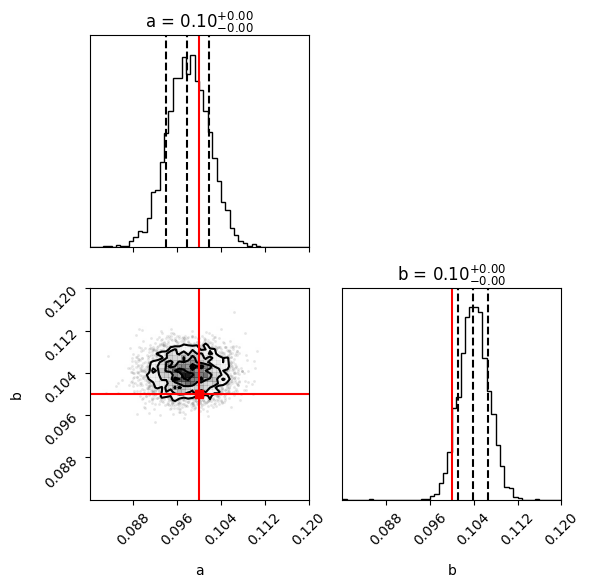

In [19]:
print("Plotting posterior marginals for MDN ...")

param_labels = ["a", "b"]

fig = corner.corner(
    samples,
    labels=param_labels,
    truths=theta_true_np,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truth_color="red",
    bins=50,  # Increase number of bins for better resolution
    range=[(0.08, 0.12), (0.08, 0.12)], # Adjust ranges
    fig=plt.figure(figsize=(6, 6)),
)

plt.tight_layout()
plt.show()

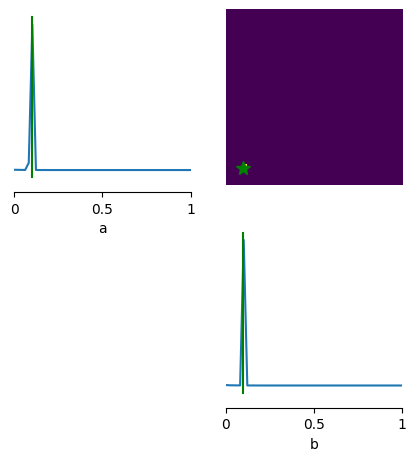

In [20]:
from vbi.plot import pairplot_numpy

limits = [(0.0, 1.0), (0.0, 1.0)]

fig, ax = pairplot_numpy(
    samples,
    points=theta_true_np.reshape(1, -1),
    figsize=(5, 5),
    limits=limits,
    labels=["a", "b"],
    upper="kde",
    diag="kde",
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["g"],
    ),
)


In [22]:
maf_estimator = MAFEstimator(n_flows=8, hidden_units=128)
maf_estimator.train(theta, stat_vec, n_iter=500, learning_rate=5e-4)
print("best epoch:", maf_estimator.best_epoch, "best val:", maf_estimator.best_val_loss)
samples = maf_estimator.sample(xo, n_samples=5000, rng=rng)[0]
shrinkage = posterior_shrinkage_numpy(theta, samples)
zscore = posterior_zscore_numpy(theta_true_np, samples)
print("True parameters:      ", theta_true_np)
print("MAF mean estimate:    ", np.mean(samples, axis=0))
print("Posterior shrinkage:  ", np.array2string(shrinkage, precision=3, separator=", "))
print("Posterior z-score:    ", np.array2string(zscore, precision=3, separator=", "))

Inferred dimensions: param_dim=2, feature_dim=4


Training:  88%|████████▊ | 442/500 [01:31<00:11,  4.84it/s, patience=20/20, train=-5.3835, val=-5.7185]


best epoch: 422 best val: -5.740458732024926
True parameters:       [0.1 0.1]
MAF mean estimate:     [0.1008262  0.10208973]
Posterior shrinkage:   [1., 1.]
Posterior z-score:     [0.132, 0.538]


In [23]:
samples = maf_estimator.sample(xo, n_samples=5000, rng=rng)[0]
samples.shape

(5000, 2)

Plotting posterior marginals for MAF ...


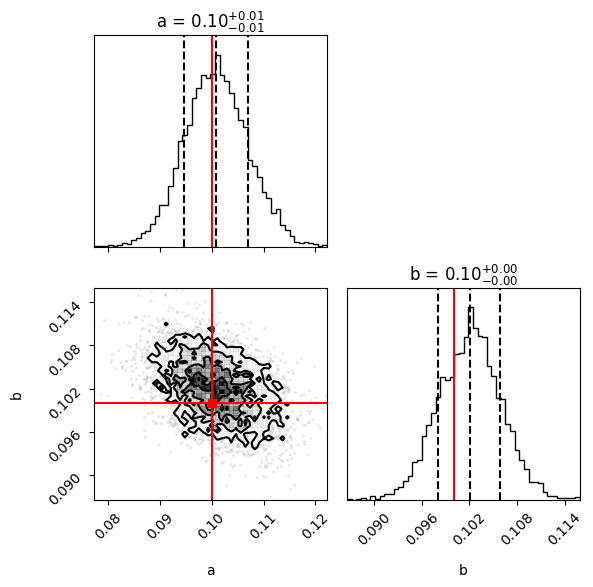

In [24]:
print("Plotting posterior marginals for MAF ...")

param_labels = ["a", "b"]

fig = corner.corner(
    samples,
    labels=param_labels,
    truths=theta_true_np,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    truth_color="red",
    bins=50, 
    fig=plt.figure(figsize=(6, 6)),
)
plt.tight_layout()
plt.show()

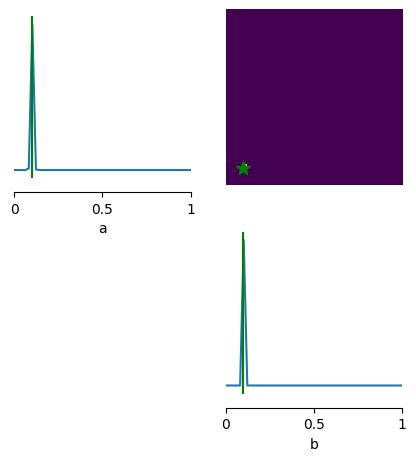

In [25]:
from vbi.plot import pairplot_numpy

limits = [(0.0, 1.0), (0.0, 1.0)]

fig, ax = pairplot_numpy(
    samples,
    points=theta_true_np.reshape(1, -1),
    figsize=(5, 5),
    limits=limits,
    labels=["a", "b"],
    upper="kde",
    diag="kde",
    fig_kwargs=dict(
        points_offdiag=dict(marker="*", markersize=10),
        points_colors=["g"],
    ),
)
